<a href="https://colab.research.google.com/github/Sheela-Nathan/Real-time-projects-packworks-/blob/main/Prediction_model_for_churn_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade -q pygsheets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
from sqlalchemy import create_engine, text
import pandas as pd
import math
import numpy as np
import datetime as dt
import calendar
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta,date
from dateutil import rrule

import pygsheets
from pygsheets import WorksheetNotFound
import google.auth
from google.colab import auth
from google.colab import files
import io

In [ ]:
auth.authenticate_user()
credentials, _ = google.auth.default()
gc = pygsheets.client.Client(credentials)

In [ ]:
# Function for reading google sheet contents
def open_sheet(key, sheet_name):

  sheet = gc.open_by_key(key)
  open_sheet = sheet.worksheet_by_title(sheet_name)
  df = open_sheet.get_as_df()

  return df

# Function for exporting dataframe to google sheets
def push_to_sheets(df, key, sheet_name, start):

  sheet = gc.open_by_key(key)
  try:
    out_dataset = sheet.worksheet_by_title(sheet_name)
  except WorksheetNotFound:
    out_dataset = sheet.add_worksheet(title = sheet_name,rows=10000,cols=100)
  out_dataset.clear()
  out_dataset.set_dataframe(df, start = start, nan = '')

# Function for updating a single value in a google sheet
def update_value(value, key, sheet_name, loc):
    sheet = gc.open_by_key(key)
    out_dataset = sheet.worksheet_by_title(sheet_name)
    out_dataset.update_value(loc,value)

In [ ]:
pack_cl = {
    "user": "packuser",
    "password": "p5cKw0Rds",
    "server_host": "159.223.60.204",
    "port": "5432",
    "database":"packdata"
}
pack_engine= create_engine('postgresql://{user}:{password}@{server_host}:{port}/{database}'.format(**pack_cl))

In [ ]:
conn=pack_engine.connect()

In [ ]:
query='''with megastores as(
select * from store
where store_type in ('super_store','packworks')
and deleted_at is null and (status IS NULL OR status = 'approved'))
SELECT Store_id,customer_id,sales_entry_id,created_at,total_amount,total_item
FROM sales_entry
WHERE store_id::text in (select store_id::text from megastores)
and created_at between '2022-01-01' and '2023-10-15'
and customer_id is not null
and deleted_at is null;'''


In [ ]:
query1='''
select store_id, area from store
where store_type in ('super_store','packworks')
and deleted_at is null
AND (status IS NULL OR status = 'approved');'''

In [ ]:
query2='''
select customer_id,area from customers
where area is not null'''

In [ ]:
df= pd.read_sql_query(sql=text(query),con=pack_engine.connect())

In [ ]:
df1=pd.read_sql_query(sql=text(query1),con=pack_engine.connect())

In [ ]:
df2=pd.read_sql_query(sql=text(query2),con=pack_engine.connect())

In [ ]:
df.head()

,store_id,customer_id,sales_entry_id,created_at,total_amount,total_item
0,0dbd8255-6984-4a78-8684-418ac913ba22,653d4af0-7094-4513-99ab-3300e4ad2b0a,9049369a-ec3f-4171-b8a8-94f85e7780b0,2023-03-21 17:59:23,1445.0,36.0
1,0dbd8255-6984-4a78-8684-418ac913ba22,943799e6-a876-4646-a251-642b3bad6ec5,12ace3ed-890d-4f90-abc8-47d1ab696a21,2023-03-21 17:09:48,6700.5,214.0
2,7d061c19-5709-432b-b0a2-06d93c8f4148,e2140e4e-328e-4326-ac2a-e79d02f55f20,db1d4cc1-ca83-44da-9e8e-a795a170517b,2023-03-21 16:55:44,192.0,29.0
3,0dbd8255-6984-4a78-8684-418ac913ba22,9d96e6bc-7e57-4e20-8405-95eac660cfb0,3c8b3b31-7459-4c00-b9ca-dc0fedbe11c7,2023-03-21 16:48:35,1032.0,38.0
4,cfce6569-8822-4ca9-a63d-62f753596bdb,b06d8ba8-3fd3-4468-b8f3-f023d5be1fe1,7ce101e8-4084-49e7-92e7-c1ed9805f334,2023-03-21 14:50:57,640.0,51.0


In [ ]:
df1.head()

,store_id,area
0,2fac04bb-225f-42ce-94fb-5848aa4dfc78,SL
1,0166e95e-6437-4cb1-b916-b360e0ffbae4,GMA
2,77358936-ad35-4488-9156-7dc5588f5bb1,SL
3,efbf7f02-e9c8-4d46-9ffd-60ca2425c0fb,STAG
4,08ced319-d570-4c3a-8722-5775f52e3ace,NM


In [ ]:
df2.head()

,customer_id,area
0,eba8db2c-75a2-45b3-bd81-e9dc78148ec8,EV
1,ebce334c-2837-4bac-9d24-964949b763f5,STAG
2,3611cf0d-22d1-4334-b8c0-5bd984a5fd16,STAG
3,4010bb38-0f52-4c56-a8ea-510d3350cece,STAG
4,4a0c283a-e12b-48a7-9bf3-d365d6564722,STAG


Converting the datetime column into year, month and day

In [ ]:
df['transaction_month_year'] = df['created_at'].dt.strftime('%Y-%m')

In [ ]:
df.head()

,store_id,customer_id,sales_entry_id,created_at,total_amount,total_item,transaction_month_year
0,0dbd8255-6984-4a78-8684-418ac913ba22,653d4af0-7094-4513-99ab-3300e4ad2b0a,9049369a-ec3f-4171-b8a8-94f85e7780b0,2023-03-21 17:59:23,1445.0,36.0,2023-03
1,0dbd8255-6984-4a78-8684-418ac913ba22,943799e6-a876-4646-a251-642b3bad6ec5,12ace3ed-890d-4f90-abc8-47d1ab696a21,2023-03-21 17:09:48,6700.5,214.0,2023-03
2,7d061c19-5709-432b-b0a2-06d93c8f4148,e2140e4e-328e-4326-ac2a-e79d02f55f20,db1d4cc1-ca83-44da-9e8e-a795a170517b,2023-03-21 16:55:44,192.0,29.0,2023-03
3,0dbd8255-6984-4a78-8684-418ac913ba22,9d96e6bc-7e57-4e20-8405-95eac660cfb0,3c8b3b31-7459-4c00-b9ca-dc0fedbe11c7,2023-03-21 16:48:35,1032.0,38.0,2023-03
4,cfce6569-8822-4ca9-a63d-62f753596bdb,b06d8ba8-3fd3-4468-b8f3-f023d5be1fe1,7ce101e8-4084-49e7-92e7-c1ed9805f334,2023-03-21 14:50:57,640.0,51.0,2023-03


Creating churn column

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2874852 entries, 0 to 2874851
Data columns (total 7 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   store_id                object        
 1   customer_id             object        
 2   sales_entry_id          object        
 3   created_at              datetime64[ns]
 4   total_amount            object        
 5   total_item              float64       
 6   transaction_month_year  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 153.5+ MB


For Megastore

In [ ]:
lasttransactiondate=df.groupby('store_id')['created_at'].max()
lasttransactiondate=lasttransactiondate.reset_index()
lasttransactiondate

,store_id,created_at
0,002df5e8-f021-40b8-8cd1-1e0a8b42e5b3,2023-09-26 11:12:53
1,004f26d9-b6ca-4e22-82b0-6691c0c66248,2023-08-26 11:05:26
2,007cbd65-1495-48b5-bf04-b85d36c01ecd,2023-10-14 09:58:14
3,007cd46d-02d6-428d-a1bb-57ac5ed09281,2023-09-29 13:40:57
4,0082dd9e-b116-48a6-93d5-3900e5b49744,2023-10-12 18:41:35
...,...,...
2107,ff86fe19-2054-48f4-9dc1-9be15aeecc3f,2023-08-18 10:45:15
2108,ff994242-e0cb-4c6d-b92e-385ef2b0158a,2023-09-21 10:11:58
2109,ffa5ef9b-18eb-475c-8ca7-e6fc04919798,2023-10-07 10:47:03
2110,ffaf4dd7-ad12-430d-ae6a-1e7e2fa6a995,2023-04-30 21:12:44


For Microstore calculating lasttransaction date

In [ ]:
lasttransactiondatemicro=df.groupby('customer_id')['created_at'].max()
lasttransactiondatemicro=lasttransactiondatemicro.reset_index()
lasttransactiondatemicro

,customer_id,created_at
0,00005610-30e0-4ea2-8e87-55cae2d2b9a2,2023-08-12 12:28:49
1,0000583a-9eff-4dc0-9088-4b91882df3ed,2023-09-28 09:48:54
2,00019102-f5ad-4509-aa71-dadcfaa94638,2023-10-09 12:00:02
3,0004cae0-a909-4058-975c-3adc171f5a3c,2023-09-17 09:29:47
4,00057e6c-4928-485b-b125-7027276c3809,2023-07-27 18:08:27
...,...,...
128185,ffff1da8-c4d4-4310-b3a7-16a8271a3e24,2023-09-22 08:47:34
128186,ffff2ca2-cdd9-4194-b21e-e215d073c816,2023-07-25 07:27:20
128187,ffff8536-8ac4-4379-9339-27dec90fbcbb,2023-09-22 07:49:45
128188,ffffa7dc-2bb0-4745-bcad-24fedb80b5c4,2023-09-28 13:32:06


for mega calculating churn column

In [ ]:
reference_date = pd.Timestamp('2023-10-15')

# Calculate the difference in days between the reference date and the last transaction date
lasttransactiondate['days_since_oct_15'] = (reference_date - lasttransactiondate['created_at']).dt.days
lasttransactiondate['churned'] = lasttransactiondate['days_since_oct_15'] > 30

lasttransactiondate

,store_id,created_at,days_since_oct_15,churned
0,002df5e8-f021-40b8-8cd1-1e0a8b42e5b3,2023-09-26 11:12:53,18,False
1,004f26d9-b6ca-4e22-82b0-6691c0c66248,2023-08-26 11:05:26,49,True
2,007cbd65-1495-48b5-bf04-b85d36c01ecd,2023-10-14 09:58:14,0,False
3,007cd46d-02d6-428d-a1bb-57ac5ed09281,2023-09-29 13:40:57,15,False
4,0082dd9e-b116-48a6-93d5-3900e5b49744,2023-10-12 18:41:35,2,False
...,...,...,...,...
2107,ff86fe19-2054-48f4-9dc1-9be15aeecc3f,2023-08-18 10:45:15,57,True
2108,ff994242-e0cb-4c6d-b92e-385ef2b0158a,2023-09-21 10:11:58,23,False
2109,ffa5ef9b-18eb-475c-8ca7-e6fc04919798,2023-10-07 10:47:03,7,False
2110,ffaf4dd7-ad12-430d-ae6a-1e7e2fa6a995,2023-04-30 21:12:44,167,True


for micro calculating churn column

In [ ]:
reference_date = pd.Timestamp('2023-10-15')

# Calculate the difference in days between the reference date and the last transaction date
lasttransactiondatemicro['days_since_oct_15'] = (reference_date - lasttransactiondatemicro['created_at']).dt.days
lasttransactiondatemicro['churned'] = lasttransactiondatemicro['days_since_oct_15'] > 30

lasttransactiondatemicro

,customer_id,created_at,days_since_oct_15,churned
0,00005610-30e0-4ea2-8e87-55cae2d2b9a2,2023-08-12 12:28:49,63,True
1,0000583a-9eff-4dc0-9088-4b91882df3ed,2023-09-28 09:48:54,16,False
2,00019102-f5ad-4509-aa71-dadcfaa94638,2023-10-09 12:00:02,5,False
3,0004cae0-a909-4058-975c-3adc171f5a3c,2023-09-17 09:29:47,27,False
4,00057e6c-4928-485b-b125-7027276c3809,2023-07-27 18:08:27,79,True
...,...,...,...,...
128185,ffff1da8-c4d4-4310-b3a7-16a8271a3e24,2023-09-22 08:47:34,22,False
128186,ffff2ca2-cdd9-4194-b21e-e215d073c816,2023-07-25 07:27:20,81,True
128187,ffff8536-8ac4-4379-9339-27dec90fbcbb,2023-09-22 07:49:45,22,False
128188,ffffa7dc-2bb0-4745-bcad-24fedb80b5c4,2023-09-28 13:32:06,16,False


Calculating the number of churned megastores

In [ ]:
# Count of churned stores
churned_store_ids = lasttransactiondate[lasttransactiondate['churned']]['store_id'].nunique()

churned_store_ids

472

Calculating the number of churned microstores

In [ ]:
churned_microstore_ids = lasttransactiondatemicro[lasttransactiondatemicro['churned']]['customer_id'].nunique()

churned_microstore_ids

47216

Finding the transaction count of each megastores and microstores based on month and year

In [ ]:
Transaction_count_store=df.groupby(['store_id','transaction_month_year'])['sales_entry_id'].count()

In [ ]:
Transaction_count_store=Transaction_count_store.reset_index(name='Transaction_Count').sort_values(by='transaction_month_year', ascending=True)

In [ ]:
Transaction_count_microstore=df.groupby(['customer_id','transaction_month_year'])['sales_entry_id'].count()

In [ ]:
Transaction_count_microstore=Transaction_count_microstore.reset_index(name='Transaction_Count_Micro').sort_values(by='transaction_month_year', ascending=True)

Calculating the growth rate of each store and microstore based on transaction count

In [ ]:
Transaction_count_store['growth_rate'] = Transaction_count_store.groupby('store_id')['Transaction_Count'].pct_change()

In [ ]:
Transaction_count_store

,store_id,transaction_month_year,Transaction_Count,growth_rate
17384,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,2022-01,30,NaN
3160,1cfe3d6d-a686-418f-9b31-83b22a56d90f,2022-01,200,NaN
4133,265f7dcb-32b1-49f2-88a8-b359bf7a74cd,2022-01,55,NaN
20047,b341b206-0656-4c83-b0c7-6196e7c54c47,2022-01,57,NaN
9017,54dee2d1-1e86-450b-86b9-527d1b2bebfe,2022-01,20,NaN
...,...,...,...,...
9609,59c49e64-c68a-48b7-8e7f-553f619fcb77,2023-10,42,0.024390
28627,f82342fa-603f-4bc8-a23d-d4cb11910617,2023-10,57,0.055556
6733,3ff41a70-018e-4aeb-9e4e-29c3f0a61674,2023-10,182,-0.305344
25861,e463bb3c-310a-462b-a46f-d3801dab2458,2023-10,220,-0.225352


In [ ]:
Transaction_count_microstore['growth_rate'] = Transaction_count_microstore.groupby('customer_id')['Transaction_Count_Micro'].pct_change()

In [ ]:
Transaction_count_microstore

,customer_id,transaction_month_year,Transaction_Count_Micro,growth_rate
377209,3d2531b6-cd58-4fed-847a-829864f3c9e2,2022-01,4,NaN
359152,3a4b246a-c1d9-421b-ac1d-069a31d949d8,2022-01,8,NaN
178290,1ce13c56-452a-4cf8-8cdc-ff66893d3e6d,2022-01,1,NaN
1237352,c64325d0-5a8c-4ee7-98dc-445072d941e0,2022-01,3,NaN
502786,51a6fa88-7d98-40f8-b8fc-8385ca7481ee,2022-01,1,NaN
...,...,...,...,...
76116,0c2494c2-ca54-46ed-b6e3-11087e05ead8,2023-10,1,0.0
728557,7578c313-a28e-43a4-a3d4-f20658d1ec9d,2023-10,2,1.0
924644,94c8f3d0-54f7-448b-97c9-780369835a81,2023-10,1,0.0
1328905,d537ff7a-043b-40c6-87d8-6d64e694cd32,2023-10,1,0.0


Converting total_amount column from object to float

In [ ]:
df['total_amount']=df['total_amount'].astype(float)

Calculating the average basket (avgtotal amount) of each store and microstore

In [ ]:
Basket_store=df.groupby(['store_id','transaction_month_year'])['total_amount'].mean()

In [ ]:
Basket_microstore=df.groupby(['customer_id','transaction_month_year'])['total_amount'].mean()

In [ ]:
Basket_store=Basket_store.reset_index(name='Average Basket').sort_values(by='transaction_month_year', ascending=True)

In [ ]:
Basket_microstore=Basket_microstore.reset_index(name='Average Basket').sort_values(by='transaction_month_year', ascending=True)

In [ ]:
#Basket_microstore=Basket_microstore['transaction_month_year'].astype(str)

In [ ]:
Basket_store

,store_id,transaction_month_year,Average Basket
17384,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,2022-01,1570.116667
3160,1cfe3d6d-a686-418f-9b31-83b22a56d90f,2022-01,778.440800
4133,265f7dcb-32b1-49f2-88a8-b359bf7a74cd,2022-01,1130.472727
20047,b341b206-0656-4c83-b0c7-6196e7c54c47,2022-01,1360.548947
9017,54dee2d1-1e86-450b-86b9-527d1b2bebfe,2022-01,416.850000
...,...,...,...
9609,59c49e64-c68a-48b7-8e7f-553f619fcb77,2023-10,2118.238095
28627,f82342fa-603f-4bc8-a23d-d4cb11910617,2023-10,1539.565789
6733,3ff41a70-018e-4aeb-9e4e-29c3f0a61674,2023-10,2143.942363
25861,e463bb3c-310a-462b-a46f-d3801dab2458,2023-10,718.619318


In [ ]:
Basket_microstore

,customer_id,transaction_month_year,Average Basket
377209,3d2531b6-cd58-4fed-847a-829864f3c9e2,2022-01,386.595000
359152,3a4b246a-c1d9-421b-ac1d-069a31d949d8,2022-01,2800.175000
178290,1ce13c56-452a-4cf8-8cdc-ff66893d3e6d,2022-01,1308.000000
1237352,c64325d0-5a8c-4ee7-98dc-445072d941e0,2022-01,308.666667
502786,51a6fa88-7d98-40f8-b8fc-8385ca7481ee,2022-01,220.000000
...,...,...,...
76116,0c2494c2-ca54-46ed-b6e3-11087e05ead8,2023-10,824.000000
728557,7578c313-a28e-43a4-a3d4-f20658d1ec9d,2023-10,19637.475000
924644,94c8f3d0-54f7-448b-97c9-780369835a81,2023-10,327.750000
1328905,d537ff7a-043b-40c6-87d8-6d64e694cd32,2023-10,1223.000000


Calculating the growth rate of each store and microstore based on Average basket

In [ ]:
Basket_store['growth_rate'] = Basket_store.groupby('store_id')['Average Basket'].pct_change()

In [ ]:
Basket_microstore['growth_rate'] = Basket_microstore.groupby('customer_id')['Average Basket'].pct_change()

In [ ]:
Basket_store


,store_id,transaction_month_year,Average Basket,growth_rate
17384,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,2022-01,1570.116667,NaN
3160,1cfe3d6d-a686-418f-9b31-83b22a56d90f,2022-01,778.440800,NaN
4133,265f7dcb-32b1-49f2-88a8-b359bf7a74cd,2022-01,1130.472727,NaN
20047,b341b206-0656-4c83-b0c7-6196e7c54c47,2022-01,1360.548947,NaN
9017,54dee2d1-1e86-450b-86b9-527d1b2bebfe,2022-01,416.850000,NaN
...,...,...,...,...
9609,59c49e64-c68a-48b7-8e7f-553f619fcb77,2023-10,2118.238095,-0.070531
28627,f82342fa-603f-4bc8-a23d-d4cb11910617,2023-10,1539.565789,-0.004105
6733,3ff41a70-018e-4aeb-9e4e-29c3f0a61674,2023-10,2143.942363,0.095392
25861,e463bb3c-310a-462b-a46f-d3801dab2458,2023-10,718.619318,-0.009906


In [ ]:
Basket_microstore

,customer_id,transaction_month_year,Average Basket,growth_rate
377209,3d2531b6-cd58-4fed-847a-829864f3c9e2,2022-01,386.595000,NaN
359152,3a4b246a-c1d9-421b-ac1d-069a31d949d8,2022-01,2800.175000,NaN
178290,1ce13c56-452a-4cf8-8cdc-ff66893d3e6d,2022-01,1308.000000,NaN
1237352,c64325d0-5a8c-4ee7-98dc-445072d941e0,2022-01,308.666667,NaN
502786,51a6fa88-7d98-40f8-b8fc-8385ca7481ee,2022-01,220.000000,NaN
...,...,...,...,...
76116,0c2494c2-ca54-46ed-b6e3-11087e05ead8,2023-10,824.000000,-0.030588
728557,7578c313-a28e-43a4-a3d4-f20658d1ec9d,2023-10,19637.475000,36.576493
924644,94c8f3d0-54f7-448b-97c9-780369835a81,2023-10,327.750000,-0.888889
1328905,d537ff7a-043b-40c6-87d8-6d64e694cd32,2023-10,1223.000000,0.052496


Calculate the average amount of time  between each transaction for mega and micro

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [ ]:
df.sort_values(['store_id', 'created_at'], inplace=True)

# Calculate the time difference between consecutive transactions
df['time_diff'] = df.groupby('store_id')['created_at'].diff()

# Extract month and year
df['transaction_month_year'] = df['created_at'].dt.to_period('M')

# Calculate the average time difference for each store for each month
monthly_avg_time_diff = df.groupby(['store_id', 'transaction_month_year'])['time_diff'].mean().reset_index()

# Print the result
monthly_avg_time_diff

,store_id,transaction_month_year,time_diff
0,002df5e8-f021-40b8-8cd1-1e0a8b42e5b3,2022-07,0 days 03:49:27.564516129
1,002df5e8-f021-40b8-8cd1-1e0a8b42e5b3,2022-08,1 days 12:42:34.350000
2,002df5e8-f021-40b8-8cd1-1e0a8b42e5b3,2022-09,0 days 08:27:05.277777777
3,002df5e8-f021-40b8-8cd1-1e0a8b42e5b3,2022-10,1 days 10:04:53.032258064
4,002df5e8-f021-40b8-8cd1-1e0a8b42e5b3,2022-11,0 days 17:56:48.680851063
...,...,...,...
29521,ffd9d9d7-c8a6-46bf-8414-b0e211c19765,2022-11,4 days 00:38:07
29522,ffd9d9d7-c8a6-46bf-8414-b0e211c19765,2022-12,1 days 04:33:37.120000
29523,ffd9d9d7-c8a6-46bf-8414-b0e211c19765,2023-03,2 days 02:09:29.978260869
29524,ffd9d9d7-c8a6-46bf-8414-b0e211c19765,2023-04,0 days 14:05:29.215686274


In [ ]:
df.sort_values(['customer_id', 'created_at'], inplace=True)

# Calculate the time difference between consecutive transactions
df['time_diff'] = df.groupby('customer_id')['created_at'].diff()

# Extract month and year
df['transaction_month_year'] = df['created_at'].dt.to_period('M')

# Calculate the average time difference for each store for each month
monthly_avg_time_diff_micro = df.groupby(['customer_id', 'transaction_month_year'])['time_diff'].mean().reset_index()

# Print the result
monthly_avg_time_diff_micro

,customer_id,transaction_month_year,time_diff
0,00005610-30e0-4ea2-8e87-55cae2d2b9a2,2023-05,NaT
1,00005610-30e0-4ea2-8e87-55cae2d2b9a2,2023-06,51 days 01:34:21
2,00005610-30e0-4ea2-8e87-55cae2d2b9a2,2023-07,19 days 03:56:11
3,00005610-30e0-4ea2-8e87-55cae2d2b9a2,2023-08,31 days 20:54:53
4,0000583a-9eff-4dc0-9088-4b91882df3ed,2022-03,NaT
...,...,...,...
1598588,ffffd7e0-62e3-4dfb-9a32-2f602e4d920a,2023-04,40 days 01:40:13
1598589,ffffd7e0-62e3-4dfb-9a32-2f602e4d920a,2023-05,9 days 21:40:20
1598590,ffffd7e0-62e3-4dfb-9a32-2f602e4d920a,2023-06,47 days 00:54:05
1598591,ffffd7e0-62e3-4dfb-9a32-2f602e4d920a,2023-07,15 days 22:08:56


Converting transaction month year to object

In [ ]:
monthly_avg_time_diff['transaction_month_year']=monthly_avg_time_diff['transaction_month_year'].astype(str)

In [ ]:
monthly_avg_time_diff_micro['transaction_month_year']=monthly_avg_time_diff_micro['transaction_month_year'].astype(str)

In [ ]:
monthly_avg_time_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29526 entries, 0 to 29525
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   store_id                29526 non-null  object         
 1   transaction_month_year  29526 non-null  object         
 2   time_diff               29464 non-null  timedelta64[ns]
dtypes: object(2), timedelta64[ns](1)
memory usage: 692.1+ KB


In [ ]:
monthly_avg_time_diff_micro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598593 entries, 0 to 1598592
Data columns (total 3 columns):
 #   Column                  Non-Null Count    Dtype          
---  ------                  --------------    -----          
 0   customer_id             1598593 non-null  object         
 1   transaction_month_year  1598593 non-null  object         
 2   time_diff               1493262 non-null  timedelta64[ns]
dtypes: object(2), timedelta64[ns](1)
memory usage: 36.6+ MB


Store and micro with maximum time difference:

In [ ]:
store_with_max_time_diff = monthly_avg_time_diff.loc[monthly_avg_time_diff['time_diff'].idxmax()]
store_with_max_time_diff


store_id                  39a98174-b179-4026-86e5-cd93b508fd2d
transaction_month_year                                 2023-10
time_diff                                    315 days 21:20:17
Name: 6085, dtype: object

In [ ]:
microstore_with_max_time_diff = monthly_avg_time_diff_micro.loc[monthly_avg_time_diff['time_diff'].idxmax()]
microstore_with_max_time_diff

customer_id               00f3e8fd-4154-4b4b-ace2-fed640fb4eb4
transaction_month_year                                 2022-07
time_diff                                     17 days 00:34:05
Name: 6085, dtype: object

Store and micro with  average time difference greater than 30 days

In [ ]:
 #Define a threshold for the maximum allowed time difference (30 days)
threshold = pd.Timedelta(days=30)

# Filter out stores where the time difference is greater than 30 days
filtered_stores = monthly_avg_time_diff[monthly_avg_time_diff['time_diff'] > threshold]

# Print the result
filtered_stores

,store_id,transaction_month_year,time_diff
1129,0840e21a-4d19-4bb7-89ad-fc0bc7df9bb5,2022-09,41 days 11:53:51
1405,0bf10284-9348-4f39-8609-a9b64f1ae23d,2022-09,75 days 09:56:09
1872,106d82d2-045b-4de5-afb1-bbb0d41d606d,2023-09,34 days 02:49:08
2012,11c5956a-77a5-46cd-956b-0dde363a4113,2023-10,36 days 07:18:09
2328,13de1cfb-842d-4f19-a4bc-85a145c975cd,2023-10,38 days 16:21:13
...,...,...,...
28090,f3e55eef-423b-438a-b59c-13511c0fb36b,2023-07,60 days 06:08:39
28760,f914486b-0388-496d-8780-93238f6c1ff4,2023-08,35 days 04:34:07
29409,ff094def-a91f-4796-9752-556a491faa22,2023-01,52 days 03:26:53
29429,ff38fd78-a080-41b8-94bb-e2c73e6245bf,2023-03,44 days 03:34:00


In [ ]:
 #Define a threshold for the maximum allowed time difference (30 days)
threshold = pd.Timedelta(days=30)

# Filter out stores where the time difference is greater than 30 days
filtered_stores_micro = monthly_avg_time_diff_micro[monthly_avg_time_diff_micro['time_diff'] > threshold]

# Print the result
filtered_stores_micro

,customer_id,transaction_month_year,time_diff
1,00005610-30e0-4ea2-8e87-55cae2d2b9a2,2023-06,51 days 01:34:21
3,00005610-30e0-4ea2-8e87-55cae2d2b9a2,2023-08,31 days 20:54:53
5,0000583a-9eff-4dc0-9088-4b91882df3ed,2022-05,85 days 21:11:12
7,0000583a-9eff-4dc0-9088-4b91882df3ed,2022-07,30 days 19:01:16
9,0000583a-9eff-4dc0-9088-4b91882df3ed,2022-09,32 days 17:18:08
...,...,...,...
1598584,ffffd7e0-62e3-4dfb-9a32-2f602e4d920a,2022-12,41 days 04:23:32
1598587,ffffd7e0-62e3-4dfb-9a32-2f602e4d920a,2023-03,39 days 23:28:36
1598588,ffffd7e0-62e3-4dfb-9a32-2f602e4d920a,2023-04,40 days 01:40:13
1598590,ffffd7e0-62e3-4dfb-9a32-2f602e4d920a,2023-06,47 days 00:54:05


In [ ]:
filtered_stores['store_id'].nunique()

66

In [ ]:
filtered_stores_micro['customer_id'].nunique()

108961

Merging mega data

In [ ]:
Mega_combined=pd.merge(Transaction_count_store,Basket_store, on=['store_id','transaction_month_year'], how='inner')

In [ ]:
Transaction_count_microstore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1598593 entries, 377209 to 1266416
Data columns (total 4 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   customer_id              1598593 non-null  object 
 1   transaction_month_year   1598593 non-null  object 
 2   Transaction_Count_Micro  1598593 non-null  int64  
 3   growth_rate              1470403 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 61.0+ MB


In [ ]:
Basket_microstore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1598593 entries, 377209 to 1266416
Data columns (total 4 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1598593 non-null  object 
 1   transaction_month_year  1598593 non-null  object 
 2   Average Basket          1598593 non-null  float64
 3   growth_rate             1470403 non-null  float64
dtypes: float64(2), object(2)
memory usage: 61.0+ MB


In [ ]:
Micro_combined=pd.merge(Transaction_count_microstore,Basket_microstore, on=['customer_id','transaction_month_year'], how='inner')

In [ ]:
Mega_combined

,store_id,transaction_month_year,Transaction_Count,growth_rate_x,Average Basket,growth_rate_y
0,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,2022-01,30,NaN,1570.116667,NaN
1,1cfe3d6d-a686-418f-9b31-83b22a56d90f,2022-01,200,NaN,778.440800,NaN
2,265f7dcb-32b1-49f2-88a8-b359bf7a74cd,2022-01,55,NaN,1130.472727,NaN
3,b341b206-0656-4c83-b0c7-6196e7c54c47,2022-01,57,NaN,1360.548947,NaN
4,54dee2d1-1e86-450b-86b9-527d1b2bebfe,2022-01,20,NaN,416.850000,NaN
...,...,...,...,...,...,...
29521,59c49e64-c68a-48b7-8e7f-553f619fcb77,2023-10,42,0.024390,2118.238095,-0.070531
29522,f82342fa-603f-4bc8-a23d-d4cb11910617,2023-10,57,0.055556,1539.565789,-0.004105
29523,3ff41a70-018e-4aeb-9e4e-29c3f0a61674,2023-10,182,-0.305344,2143.942363,0.095392
29524,e463bb3c-310a-462b-a46f-d3801dab2458,2023-10,220,-0.225352,718.619318,-0.009906


In [ ]:
Micro_combined

,customer_id,transaction_month_year,Transaction_Count_Micro,growth_rate_x,Average Basket,growth_rate_y
0,3d2531b6-cd58-4fed-847a-829864f3c9e2,2022-01,4,NaN,386.595000,NaN
1,3a4b246a-c1d9-421b-ac1d-069a31d949d8,2022-01,8,NaN,2800.175000,NaN
2,1ce13c56-452a-4cf8-8cdc-ff66893d3e6d,2022-01,1,NaN,1308.000000,NaN
3,c64325d0-5a8c-4ee7-98dc-445072d941e0,2022-01,3,NaN,308.666667,NaN
4,51a6fa88-7d98-40f8-b8fc-8385ca7481ee,2022-01,1,NaN,220.000000,NaN
...,...,...,...,...,...,...
1598588,0c2494c2-ca54-46ed-b6e3-11087e05ead8,2023-10,1,0.0,824.000000,-0.030588
1598589,7578c313-a28e-43a4-a3d4-f20658d1ec9d,2023-10,2,1.0,19637.475000,36.576493
1598590,94c8f3d0-54f7-448b-97c9-780369835a81,2023-10,1,0.0,327.750000,-0.888889
1598591,d537ff7a-043b-40c6-87d8-6d64e694cd32,2023-10,1,0.0,1223.000000,0.052496


In [ ]:
Merged_mega=pd.merge(Mega_combined,monthly_avg_time_diff, on=['store_id','transaction_month_year'], how='inner')

In [ ]:
Merged_micro=pd.merge(Micro_combined,monthly_avg_time_diff_micro, on=['customer_id','transaction_month_year'], how='inner')

In [ ]:
Merged_mega

,store_id,transaction_month_year,Transaction_Count,growth_rate_x,Average Basket,growth_rate_y,time_diff
0,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,2022-01,30,NaN,1570.116667,NaN,0 days 19:57:39.068965517
1,1cfe3d6d-a686-418f-9b31-83b22a56d90f,2022-01,200,NaN,778.440800,NaN,0 days 03:13:51
2,265f7dcb-32b1-49f2-88a8-b359bf7a74cd,2022-01,55,NaN,1130.472727,NaN,0 days 09:18:13.185185185
3,b341b206-0656-4c83-b0c7-6196e7c54c47,2022-01,57,NaN,1360.548947,NaN,0 days 12:04:11.375000
4,54dee2d1-1e86-450b-86b9-527d1b2bebfe,2022-01,20,NaN,416.850000,NaN,0 days 00:00:20.473684210
...,...,...,...,...,...,...,...
29521,59c49e64-c68a-48b7-8e7f-553f619fcb77,2023-10,42,0.024390,2118.238095,-0.070531,0 days 14:59:18.333333333
29522,f82342fa-603f-4bc8-a23d-d4cb11910617,2023-10,57,0.055556,1539.565789,-0.004105,0 days 08:30:46.245614035
29523,3ff41a70-018e-4aeb-9e4e-29c3f0a61674,2023-10,182,-0.305344,2143.942363,0.095392,0 days 01:51:02.763736263
29524,e463bb3c-310a-462b-a46f-d3801dab2458,2023-10,220,-0.225352,718.619318,-0.009906,0 days 01:31:31.281818181


In [ ]:
Merged_micro

,customer_id,transaction_month_year,Transaction_Count_Micro,growth_rate_x,Average Basket,growth_rate_y,time_diff
0,3d2531b6-cd58-4fed-847a-829864f3c9e2,2022-01,4,NaN,386.595000,NaN,5 days 17:06:44.666666666
1,3a4b246a-c1d9-421b-ac1d-069a31d949d8,2022-01,8,NaN,2800.175000,NaN,1 days 09:26:01.571428571
2,1ce13c56-452a-4cf8-8cdc-ff66893d3e6d,2022-01,1,NaN,1308.000000,NaN,NaT
3,c64325d0-5a8c-4ee7-98dc-445072d941e0,2022-01,3,NaN,308.666667,NaN,1 days 01:15:14.500000
4,51a6fa88-7d98-40f8-b8fc-8385ca7481ee,2022-01,1,NaN,220.000000,NaN,NaT
...,...,...,...,...,...,...,...
1598588,0c2494c2-ca54-46ed-b6e3-11087e05ead8,2023-10,1,0.0,824.000000,-0.030588,32 days 01:28:47
1598589,7578c313-a28e-43a4-a3d4-f20658d1ec9d,2023-10,2,1.0,19637.475000,36.576493,10 days 23:13:54.500000
1598590,94c8f3d0-54f7-448b-97c9-780369835a81,2023-10,1,0.0,327.750000,-0.888889,32 days 23:31:44
1598591,d537ff7a-043b-40c6-87d8-6d64e694cd32,2023-10,1,0.0,1223.000000,0.052496,17 days 22:59:26


In [ ]:
Merged_mega.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29526 entries, 0 to 29525
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   store_id                29526 non-null  object         
 1   transaction_month_year  29526 non-null  object         
 2   Transaction_Count       29526 non-null  int64          
 3   growth_rate_x           27414 non-null  float64        
 4   Average Basket          29526 non-null  float64        
 5   growth_rate_y           27414 non-null  float64        
 6   time_diff               29464 non-null  timedelta64[ns]
dtypes: float64(3), int64(1), object(2), timedelta64[ns](1)
memory usage: 1.8+ MB


In [ ]:
Merged_micro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1598593 entries, 0 to 1598592
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype          
---  ------                   --------------    -----          
 0   customer_id              1598593 non-null  object         
 1   transaction_month_year   1598593 non-null  object         
 2   Transaction_Count_Micro  1598593 non-null  int64          
 3   growth_rate_x            1470403 non-null  float64        
 4   Average Basket           1598593 non-null  float64        
 5   growth_rate_y            1470403 non-null  float64        
 6   time_diff                1493262 non-null  timedelta64[ns]
dtypes: float64(3), int64(1), object(2), timedelta64[ns](1)
memory usage: 97.6+ MB


In [ ]:
MegaData=pd.merge(Merged_mega,lasttransactiondate, on='store_id', how ='inner')

In [ ]:
MicroData=pd.merge(Merged_micro,lasttransactiondatemicro, on='customer_id', how ='inner')

In [ ]:
MegaData

,store_id,transaction_month_year,Transaction_Count,growth_rate_x,Average Basket,growth_rate_y,time_diff,created_at,days_since_oct_15,churned
0,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,2022-01,30,NaN,1570.116667,NaN,0 days 19:57:39.068965517,2023-08-25 19:25:19,50,True
1,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,2022-02,21,-0.300000,1259.000000,-0.198149,1 days 13:48:36.428571428,2023-08-25 19:25:19,50,True
2,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,2022-03,61,1.904762,1478.959016,0.174709,0 days 11:47:47.229508196,2023-08-25 19:25:19,50,True
3,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,2022-04,61,0.000000,1013.147541,-0.314959,0 days 11:28:29.163934426,2023-08-25 19:25:19,50,True
4,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,2022-05,58,-0.049180,486.189655,-0.520120,0 days 03:40:12.655172413,2023-08-25 19:25:19,50,True
...,...,...,...,...,...,...,...,...,...,...
29521,151062a4-cd70-45fd-b86d-0c8d3763644e,2023-10,1,NaN,142.000000,NaN,NaT,2023-10-07 09:25:31,7,False
29522,860b3ebc-b9cd-46d3-9bb2-d2c19f677be2,2023-10,35,NaN,341.445714,NaN,0 days 00:02:19.264705882,2023-10-12 21:48:01,2,False
29523,d4f38177-3ee0-42c3-a882-a3775e18579f,2023-10,13,NaN,119.986154,NaN,0 days 10:30:32.833333333,2023-10-14 19:53:05,0,False
29524,d4f108ca-b52f-4b81-91d9-46aa57d0f94b,2023-10,8,NaN,721.093750,NaN,1 days 03:38:01,2023-10-14 12:06:11,0,False


In [ ]:
MicroData

,customer_id,transaction_month_year,Transaction_Count_Micro,growth_rate_x,Average Basket,growth_rate_y,time_diff,created_at,days_since_oct_15,churned
0,3d2531b6-cd58-4fed-847a-829864f3c9e2,2022-01,4,NaN,386.595000,NaN,5 days 17:06:44.666666666,2023-09-03 08:00:19,41,True
1,3d2531b6-cd58-4fed-847a-829864f3c9e2,2022-02,2,-0.500000,503.375000,0.302073,17 days 08:40:36,2023-09-03 08:00:19,41,True
2,3d2531b6-cd58-4fed-847a-829864f3c9e2,2022-03,1,-0.500000,528.250000,0.049416,14 days 06:34:31,2023-09-03 08:00:19,41,True
3,3d2531b6-cd58-4fed-847a-829864f3c9e2,2022-05,3,2.000000,672.083333,0.272283,25 days 16:21:44,2023-09-03 08:00:19,41,True
4,3d2531b6-cd58-4fed-847a-829864f3c9e2,2022-06,1,-0.666667,1020.000000,0.517669,35 days 23:18:58,2023-09-03 08:00:19,41,True
...,...,...,...,...,...,...,...,...,...,...
1598588,46be0c24-63ca-483c-81c1-39189ff43378,2023-10,2,NaN,4597.000000,NaN,5 days 22:16:16,2023-10-09 15:24:07,5,False
1598589,94b8cc01-7b4a-462d-9019-1b2ff4301e0a,2023-10,1,NaN,359.500000,NaN,NaT,2023-10-12 21:09:26,2,False
1598590,94b83706-fdc9-4ebf-a13e-27be4f54a518,2023-10,1,NaN,1670.280000,NaN,NaT,2023-10-14 14:39:25,0,False
1598591,46d1934d-fc17-4926-8e65-1bfef1797e38,2023-10,1,NaN,728.000000,NaN,NaT,2023-10-12 15:44:10,2,False


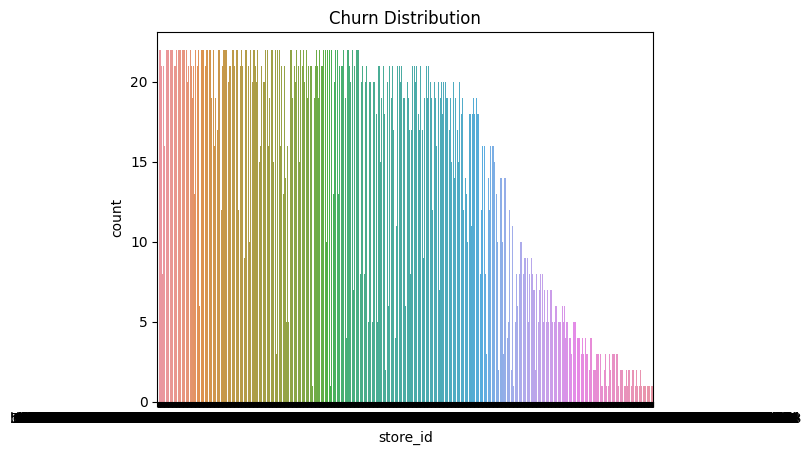

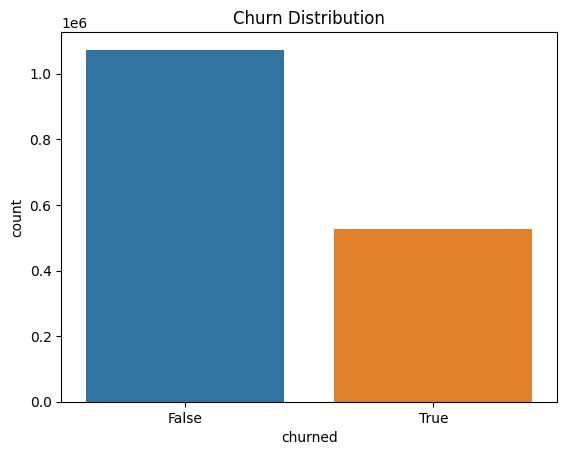

In [ ]:
#Distribution of Churn:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=MegaData, x='store_id')
plt.title('Churn Distribution')
plt.show()

sns.countplot(data=MicroData, x='churned')
plt.title('Churn Distribution')
plt.show()

Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
MegaData['churned'] = le.fit_transform(MegaData['churned'])

MicroData['churned'] = le.fit_transform(MicroData['churned'])

MegaData['transaction_month_year'] = le.fit_transform(MegaData['transaction_month_year'])
MicroData['transaction_month_year'] = le.fit_transform(MicroData['transaction_month_year'])


In [ ]:
#Descriptive Statistics:
MegaData.describe()

,transaction_month_year,Transaction_Count,growth_rate_x,Average Basket,growth_rate_y,time_diff,days_since_oct_15,churned
count,29526.000000,29526.000000,27414.000000,29526.000000,2.741400e+04,29464,29526.000000,29526.000000
mean,10.924710,97.366795,0.446617,1257.773316,inf,0 days 21:43:45.310324988,31.298381,0.173169
std,6.188689,200.169833,5.788618,3481.523378,NaN,3 days 22:58:00.541272970,73.054666,0.378400
min,0.000000,1.000000,-0.995902,0.000000,-1.000000e+00,0 days 00:00:15,0.000000,0.000000
25%,6.000000,36.000000,-0.083333,521.810417,-1.509635e-01,0 days 06:28:26.787549406,1.000000,0.000000
50%,11.000000,57.000000,0.000000,915.429396,1.140954e-03,0 days 11:19:24.534774435,7.000000,0.000000
75%,16.000000,90.000000,0.100000,1497.482582,1.871938e-01,0 days 19:04:22.225961538,22.000000,0.000000
max,21.000000,5489.000000,472.000000,486466.875000,inf,315 days 21:20:17,651.000000,1.000000


In [ ]:
MicroData.describe()

,transaction_month_year,Transaction_Count_Micro,growth_rate_x,Average Basket,growth_rate_y,time_diff,days_since_oct_15,churned
count,1.598593e+06,1.598593e+06,1.470403e+06,1.598593e+06,1.470403e+06,1493262,1.598593e+06,1.598593e+06
mean,1.100665e+01,1.798364e+00,9.560778e-02,1.184982e+03,inf,29 days 14:12:08.579951671,4.359287e+01,3.287904e-01
std,5.957758e+00,6.804635e+00,9.954304e-01,1.240123e+04,NaN,19 days 12:36:07.807195112,7.275227e+01,4.697738e-01
min,0.000000e+00,1.000000e+00,-9.988386e-01,0.000000e+00,-1.000000e+00,0 days 00:00:02,0.000000e+00,0.000000e+00
25%,6.000000e+00,1.000000e+00,0.000000e+00,4.320000e+02,-2.808646e-01,19 days 00:31:02,8.000000e+00,0.000000e+00
50%,1.100000e+01,1.000000e+00,0.000000e+00,8.140000e+02,0.000000e+00,28 days 20:33:31,2.000000e+01,0.000000e+00
75%,1.600000e+01,1.000000e+00,0.000000e+00,1.388000e+03,3.983051e-01,35 days 20:03:58,3.800000e+01,1.000000e+00
max,2.100000e+01,1.799000e+03,3.060000e+02,1.500000e+07,inf,570 days 21:45:33,6.510000e+02,1.000000e+00


<ipython-input-78-2f004e5cbefc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix =MegaData.corr()


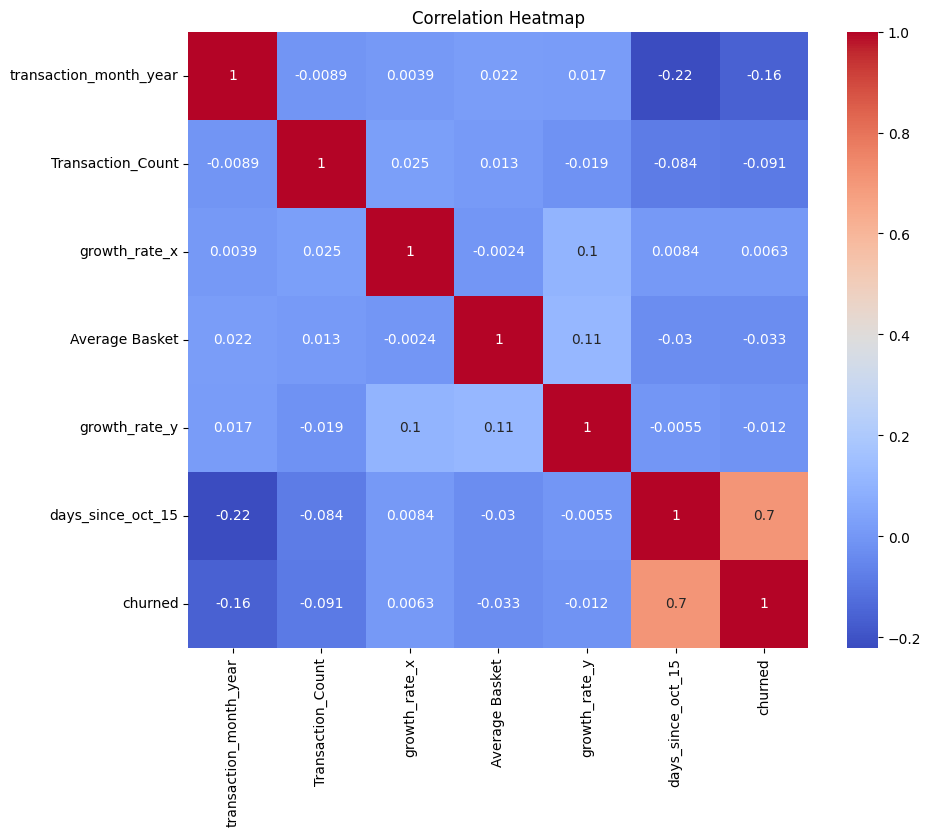

<ipython-input-78-2f004e5cbefc>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix1 =MicroData.corr()


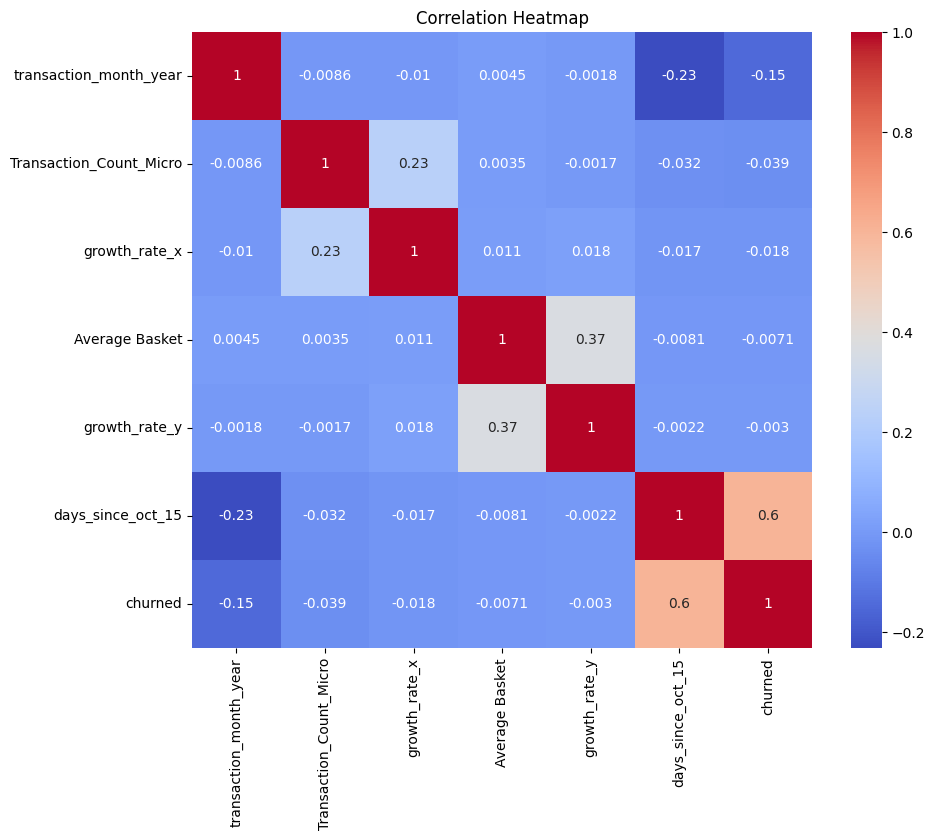

In [ ]:
#Correlation Analysis:
corr_matrix =MegaData.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

corr_matrix1 =MicroData.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Data cleaning of Mega:

In [ ]:
MegaData['growth_rate_x']=MegaData['growth_rate_x'].fillna(0)
MegaData['growth_rate_y']=MegaData['growth_rate_y'].fillna(0)
replacement_value=0
MegaData['growth_rate_y']=MegaData['growth_rate_y'].replace(['NA','inf'],replacement_value)

In [ ]:
inf_rows = MegaData[MegaData['growth_rate_y'] == float('inf')]
inf_rows

,store_id,transaction_month_year,Transaction_Count,growth_rate_x,Average Basket,growth_rate_y,time_diff,created_at,days_since_oct_15,churned
28663,fb97ffaa-4a44-4896-81ba-6b0b632cb504,19,7,6.0,530.857143,inf,3 days 17:34:09.571428571,2023-09-29 07:25:27,15,0


In [ ]:
MegaData = MegaData[~MegaData['growth_rate_y'].isin([float('inf'), -float('inf')])]

In [ ]:
replacement_timedelta = pd.Timedelta(0, unit='D')  # Replace with 0 days, but you can specify a different value

# Replace NaT with the specified timedelta in the 'time_diff' column
MegaData['time_diff'] = MegaData['time_diff'].fillna(replacement_timedelta)

In [ ]:
MegaData.dropna()

,store_id,transaction_month_year,Transaction_Count,growth_rate_x,Average Basket,growth_rate_y,time_diff,created_at,days_since_oct_15,churned
0,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,0,30,0.000000,1570.116667,0.000000,0 days 19:57:39.068965517,2023-08-25 19:25:19,50,1
1,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,1,21,-0.300000,1259.000000,-0.198149,1 days 13:48:36.428571428,2023-08-25 19:25:19,50,1
2,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,2,61,1.904762,1478.959016,0.174709,0 days 11:47:47.229508196,2023-08-25 19:25:19,50,1
3,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,3,61,0.000000,1013.147541,-0.314959,0 days 11:28:29.163934426,2023-08-25 19:25:19,50,1
4,9ca6dfd5-7133-4671-8f6e-12bcddcec70a,4,58,-0.049180,486.189655,-0.520120,0 days 03:40:12.655172413,2023-08-25 19:25:19,50,1
...,...,...,...,...,...,...,...,...,...,...
29521,151062a4-cd70-45fd-b86d-0c8d3763644e,21,1,0.000000,142.000000,0.000000,0 days 00:00:00,2023-10-07 09:25:31,7,0
29522,860b3ebc-b9cd-46d3-9bb2-d2c19f677be2,21,35,0.000000,341.445714,0.000000,0 days 00:02:19.264705882,2023-10-12 21:48:01,2,0
29523,d4f38177-3ee0-42c3-a882-a3775e18579f,21,13,0.000000,119.986154,0.000000,0 days 10:30:32.833333333,2023-10-14 19:53:05,0,0
29524,d4f108ca-b52f-4b81-91d9-46aa57d0f94b,21,8,0.000000,721.093750,0.000000,1 days 03:38:01,2023-10-14 12:06:11,0,0


In [ ]:
MegaData['growth_rate_x']=MegaData['growth_rate_x'].astype(int)
MegaData['growth_rate_y']=MegaData['growth_rate_y'].astype(int)
MegaData['Average Basket	']=MegaData['Average Basket'].astype(int)

In [ ]:
MegaData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29525 entries, 0 to 29525
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   store_id                29525 non-null  object         
 1   transaction_month_year  29525 non-null  int64          
 2   Transaction_Count       29525 non-null  int64          
 3   growth_rate_x           29525 non-null  int64          
 4   Average Basket          29525 non-null  float64        
 5   growth_rate_y           29525 non-null  int64          
 6   time_diff               29525 non-null  timedelta64[ns]
 7   created_at              29525 non-null  datetime64[ns] 
 8   days_since_oct_15       29525 non-null  int64          
 9   churned                 29525 non-null  int64          
 10  Average Basket	         29525 non-null  int64          
dtypes: datetime64[ns](1), float64(1), int64(7), object(1), timedelta64[ns](1)
memory usage: 2.7+ 

In [ ]:
y = MegaData['churned'].values
X = MegaData.drop(columns = ['churned','store_id','time_diff','created_at'])

# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

Datacleaning of Micro

In [ ]:
MicroData['growth_rate_x']=MicroData['growth_rate_x'].fillna(0)
MicroData['growth_rate_y']=MicroData['growth_rate_y'].fillna(0)
replacement_value=0
MicroData['growth_rate_y']=MicroData['growth_rate_y'].replace(['NA','inf'],replacement_value)

In [ ]:
MicroData = MicroData[~MicroData['growth_rate_y'].isin([float('inf'), -float('inf')])]

In [ ]:
replacement_timedelta = pd.Timedelta(0, unit='D')  # Replace with 0 days, but you can specify a different value

# Replace NaT with the specified timedelta in the 'time_diff' column
MicroData['time_diff'] = MicroData['time_diff'].fillna(replacement_timedelta)

In [ ]:
MicroData['growth_rate_x']=MicroData['growth_rate_x'].astype(int)
MicroData['growth_rate_y']=MicroData['growth_rate_y'].astype(int)
MicroData['Average Basket	']=MicroData['Average Basket'].astype(int)

In [ ]:
MicroData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1598568 entries, 0 to 1598592
Data columns (total 11 columns):
 #   Column                   Non-Null Count    Dtype          
---  ------                   --------------    -----          
 0   customer_id              1598568 non-null  object         
 1   transaction_month_year   1598568 non-null  int64          
 2   Transaction_Count_Micro  1598568 non-null  int64          
 3   growth_rate_x            1598568 non-null  int64          
 4   Average Basket           1598568 non-null  float64        
 5   growth_rate_y            1598568 non-null  int64          
 6   time_diff                1598568 non-null  timedelta64[ns]
 7   created_at               1598568 non-null  datetime64[ns] 
 8   days_since_oct_15        1598568 non-null  int64          
 9   churned                  1598568 non-null  int64          
 10  Average Basket	          1598568 non-null  int64          
dtypes: datetime64[ns](1), float64(1), int64(7), object

In [ ]:
y1 = MicroData['churned'].values
X1 = MicroData.drop(columns = ['churned','customer_id','time_diff','created_at'])

# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X1.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X1)
X1 = pd.DataFrame(scaler.transform(X1))
X1.columns = features

Logistic Regression:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, precision_score, recall_score,f1_score,confusion_matrix, roc_curve, roc_auc_score,accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)
prediction_test = model.predict(X_test)

accuracy=accuracy_score(y_test, prediction_test)
precision=precision_score(y_test, prediction_test)
recall = recall_score(y_test, prediction_test)
f1_score =f1_score(y_test, prediction_test)
roc_curve =roc_curve(y_test, prediction_test)
roc_auc_score=roc_auc_score(y_test, prediction_test)
confusion_matrix=confusion_matrix(y_test,prediction_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)
print("roc_curve:", roc_curve)
print("roc_auc_score:", roc_auc_score)

print("confusion_matrix:",confusion_matrix)

Accuracy: 0.9454730187401219
Precision: 1.0
Recall: 0.6901860166773572
F1-Score: 0.8166982922201138
roc_curve: (array([0., 0., 1.]), array([0.        , 0.69018602, 1.        ]), array([2, 1, 0]))
roc_auc_score: 0.8450930083386786
confusion_matrix: [[7299    0]
 [ 483 1076]]


Axes(0.125,0.11;0.775x0.77)


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


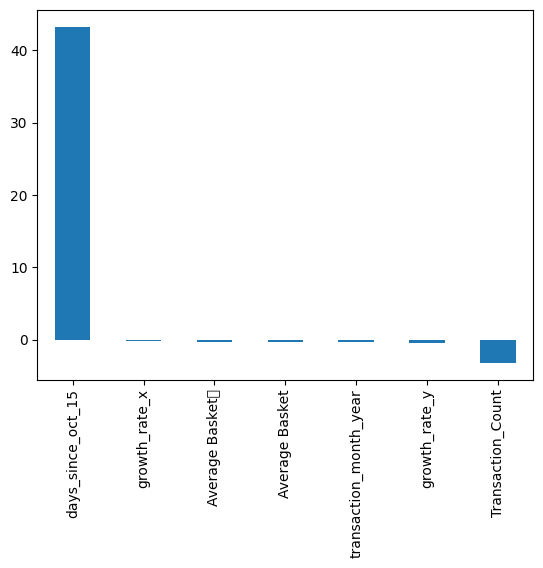

In [ ]:
weights = pd.Series(model.coef_[0],
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))

In [ ]:
weights

transaction_month_year    -0.307543
Transaction_Count         -3.157830
growth_rate_x             -0.134002
Average Basket            -0.290129
growth_rate_y             -0.421919
days_since_oct_15         43.222188
Average Basket\t          -0.290094
dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, precision_score, recall_score,f1_score,confusion_matrix, roc_curve, roc_auc_score,accuracy_score
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=101)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X1_train, y1_train)
prediction_test = model.predict(X1_test)

accuracy=accuracy_score(y1_test, prediction_test)
precision=precision_score(y1_test, prediction_test)
recall = recall_score(y1_test, prediction_test)
f1_score =f1_score(y1_test, prediction_test)
roc_curve =roc_curve(y1_test, prediction_test)
roc_auc_score=roc_auc_score(y1_test, prediction_test)
confusion_matrix=confusion_matrix(y1_test,prediction_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)
print("roc_curve:", roc_curve)
print("roc_auc_score:", roc_auc_score)
print("confusion_matrix:",confusion_matrix)

Accuracy: 0.9885877169386806
Precision: 1.0
Recall: 0.965311800832821
F1-Score: 0.9823497731237967
roc_curve: (array([0., 0., 1.]), array([0.       , 0.9653118, 1.       ]), array([2, 1, 0]))
roc_auc_score: 0.9826559004164105
confusion_matrix: [[321794      0]
 [  5473 152304]]


Axes(0.125,0.11;0.775x0.77)


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


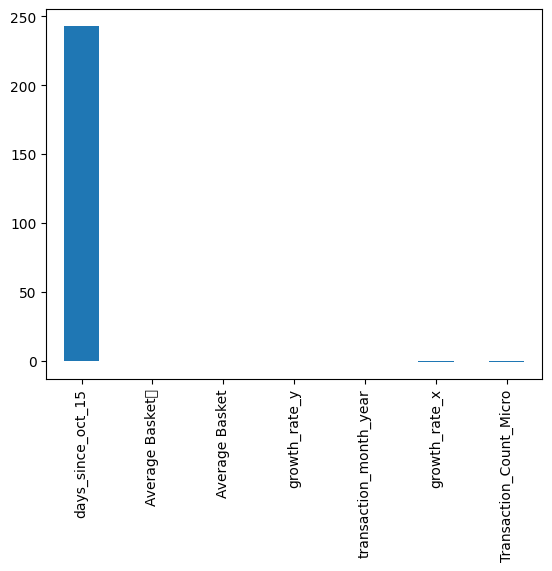

In [ ]:
weights1 = pd.Series(model.coef_[0],
                 index=X1.columns.values)
print (weights1.sort_values(ascending = False)[:10].plot(kind='bar'))

In [ ]:
weights1

transaction_month_year      -0.093806
Transaction_Count_Micro     -0.732933
growth_rate_x               -0.302691
Average Basket              -0.020774
growth_rate_y               -0.022738
days_since_oct_15          242.950648
Average Basket\t            -0.020768
dtype: float64

Random Forest:


Support Vector Machine

In [ ]:
from sklearn.svm import SVC

model.svm = SVC(kernel='linear')
model.svm.fit(X_train,y_train)
preds = model.svm.predict(X_test)

preds = model.svm.predict(X_test)

accuracy=accuracy_score(y_test, preds)
precision=precision_score(y_test, preds)
recall = recall_score(y_test, preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.956875141115376
Precision: 1.0
Recall: 0.7549711353431687


In [ ]:
from sklearn.svm import SVC

model.svm = SVC(kernel='linear')
model.svm.fit(X1_train,y1_train)
preds = model.svm.predict(X1_test)

preds1 = model.svm.predict(X1_test)

accuracy=accuracy_score(y1_test, preds1)
precision=precision_score(y1_test, preds1)
recall = recall_score(y1_test, preds1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

In [ ]:
###from sklearn.ensemble import RandomForestClassifier
###X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test1 = model_rf.predict(X_test)

accuracy=accuracy_score(y_test, prediction_test1)
precision=precision_score(y_test, prediction_test1)
recall = recall_score(y_test, prediction_test1)
#f1_score =f1_score(y_test, prediction_test1)
#roc_curve =roc_curve(y_test, prediction_test1)
#roc_auc_score=roc_auc_score(y_test, prediction_test1)
#confusion_matrix=confusion_matrix(y_test,prediction_test1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
#print("F1-Score:", f1_score)
#print("roc_curve:", roc_curve)
#print("roc_auc_score:", roc_auc_score)

#print("confusion_matrix:",confusion_matrix)


In [ ]:

model_rf.fit(X1_train, y1_train)

# Make predictions
prediction_test1 = model_rf.predict(X1_test)

accuracy=accuracy_score(y1_test, prediction_test1)
precision=precision_score(y1_test, prediction_test1)
recall = recall_score(y1_test, prediction_test1)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)